# LSTM on Amazon fine food reviews

In [0]:
import pandas as pd

In [0]:
import sqlite3

<h2>1. Reading dataset</h2>

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final.sqlite') 
conn = sqlite3.connect('final.sqlite')

In [0]:
c = conn.cursor()

In [0]:
link2="https://drive.google.com/open?id=1ikpehnH7UMKa6ZTDToua0wU2QAiXdVa5"

In [12]:
fluff, id = link2.split('=')
print (id)

1ikpehnH7UMKa6ZTDToua0wU2QAiXdVa5


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Reviews.csv')  
df3 = pd.read_csv('Reviews.csv')

In [0]:
df=pd.read_sql_query("""
SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000
""",conn)

In [0]:
final=df.sort_values("Time")

In [16]:
final.shape

(100000, 12)

In [0]:
df=final[['Time','Text','CleanedText']]

In [18]:
print(final['Score'].value_counts())

1    85197
0    14803
Name: Score, dtype: int64


<h2>2. Train Test split</h2>

In [0]:
X_train=df.iloc[:70000,:]
X_test=df.iloc[70001:,]
y_train=final.iloc[:70000,final.columns.get_loc("Score")]
y_test=final.iloc[70001:,final.columns.get_loc("Score")]

<h2>3.Data Preprocessing</h2>

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train['CleanedText'])

<70000x31484 sparse matrix of type '<class 'numpy.int64'>'
	with 2115248 stored elements in Compressed Sparse Row format>

> Converting the text data to vectors with Bag of Words

In [0]:
dictofwords=vectorizer.vocabulary_

>We have a attribute like vocabulary_ which gives the count of the word repeated in
text

In [23]:
type(dictofwords)

dict

In [24]:
len(dictofwords)

31484

In [0]:
import operator
sorted_by_value = dict(sorted(dictofwords.items(), key=operator.itemgetter(0), reverse=True))

rank = 0
last_value = len(dictofwords)
ranked_dict = dict()
for name in sorted_by_value:
    this_value = dictofwords[name]
    if this_value != last_value:
        rank += 1
    ranked_dict[name] = rank
    last_value = this_value

>https://stackoverflow.com/questions/23641054/adding-a-rank-to-a-dict-in-python <br>
>Adding the ranks to a dict value reference the above link

In [0]:
final_train=[]

i=0;
for i in X_train.CleanedText:
    i=i.split()
    addranks=[]
    for j in i:
        add=ranked_dict.get(j,0) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.get.html
        addranks.append(add)
    final_train.append(addranks)

In [ ]:
final_test=[]

i=0;
for i in X_test.CleanedText:
    i=i.split()
    addranks=[]
    for j in i:
        add=ranked_dict.get(j,0) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.get.html
        addranks.append(add)
    final_test.append(addranks)
  

>Adding the ranks of train data to the train as well as test dataset is to avoid data leakage

In [28]:
print(X_train.CleanedText[1:2])
print(final_train[2])

30    rememb see show air televis year ago child sis...
Name: CleanedText, dtype: object
[29136, 1113, 490, 13578, 22252, 22193, 31258, 5760, 22953, 24347, 26464, 1623, 13578]


In [29]:
print(X_test.CleanedText[:1])
print(final_test[1])

30320    look various litter option environment friend ...
Name: CleanedText, dtype: object
[17246, 22621, 20547, 7727, 28963, 17246, 3060, 21855, 19059, 18967, 30281, 3060, 10306, 308, 15385, 5058, 5651, 23511, 16053, 20547, 7727, 10306, 23585, 7183, 4055, 12227, 22621, 10306]


<h2>4. Machine Learning Model</h2>

In [30]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [31]:
# truncate and/or pad input sequences
max_review_length = 300
X_train = sequence.pad_sequences(final_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(final_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])
print(X_test.shape)

(70000, 300)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

>We add padding because if the datapoints have different sizes so we cannot perform
batch wise LSTM. So, if we add padding values we can form Batch wise

In [0]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
# create the model
embedding_vecor_length =100
model = Sequential()
model.add(Embedding(70000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 100)          7000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 7,080,501
Trainable params: 7,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
h=model.fit(X_train,
          y_train,
          batch_size=400,
          validation_data=(X_test, y_test),
          epochs=10)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 29999 samples
Epoch 1/10
70000/70000 [==============================] - 914s 13ms/step - loss: 0.3412 - acc: 0.8751 - val_loss: 0.3079 - val_acc: 0.8688
Epoch 2/10
70000/70000 [==============================] - 915s 13ms/step - loss: 0.2236 - acc: 0.9117 - val_loss: 0.2726 - val_acc: 0.8855
Epoch 3/10
70000/70000 [==============================] - 912s 13ms/step - loss: 0.2002 - acc: 0.9216 - val_loss: 0.2788 - val_acc: 0.8883
Epoch 4/10
70000/70000 [==============================] - 918s 13ms/step - loss: 0.1850 - acc: 0.9270 - val_loss: 0.2936 - val_acc: 0.8878
Epoch 5/10
70000/70000 [==============================] - 913s 13ms/step - loss: 0.1726 - acc: 0.9342 - val_loss: 0.2847 - val_acc: 0.8825
Epoch 6/10
70000/70000 [==============================] - 921s 13ms/step - loss: 0.1989 - acc: 0.9248 - val_loss: 0.3067 - val_acc: 0.8856
Epoch 7/10
70000/70000 [==============================] - 886s 13ms/

> We got an accuracy of 88.05%

In [0]:
# create the model
embedding_vecor_length =128
model = Sequential()
model.add(Embedding(70000, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.5))
model.add(LSTM(192))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 128)          8960000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 192)               246528    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 193       
Total params: 9,206,721
Trainable params: 9,206,721
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
h=model.fit(X_train,
          y_train,
          batch_size=50,
          validation_data=(X_test, y_test),
          epochs=5)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 29999 samples
Epoch 1/5
70000/70000 [==============================] - 1855s 27ms/step - loss: 0.2325 - acc: 0.9087 - val_loss: 0.2323 - val_acc: 0.9083
Epoch 2/5
70000/70000 [==============================] - 1849s 26ms/step - loss: 0.1659 - acc: 0.9368 - val_loss: 0.2199 - val_acc: 0.9120
Epoch 3/5
70000/70000 [==============================] - 1858s 27ms/step - loss: 0.1396 - acc: 0.9479 - val_loss: 0.2415 - val_acc: 0.9103
Epoch 4/5
70000/70000 [==============================] - 1879s 27ms/step - loss: 0.1175 - acc: 0.9563 - val_loss: 0.2607 - val_acc: 0.9070
Epoch 5/5
70000/70000 [==============================] - 1860s 27ms/step - loss: 0.0983 - acc: 0.9640 - val_loss: 0.2607 - val_acc: 0.9079
Accuracy: 90.79%


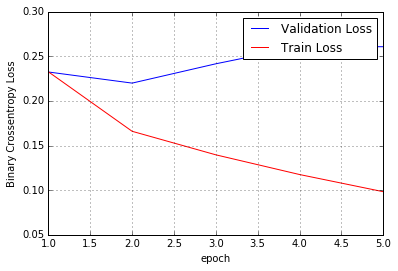

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,5+1))

vy = h.history['val_loss']
ty = h.history['loss']
plt_dynamic(x, vy, ty, ax)

> We got an accuracy of 90.79% and the difference between the train and test split is not much in difference let us change the parameters

In [33]:
# create the model
embedding_vecor_length =92
model = Sequential()
model.add(Embedding(70000, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.8))
model.add(LSTM(42))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 92)           6440000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 92)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 42)                22680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 43        
Total params: 6,462,723
Trainable params: 6,462,723
Non-trainable params: 0
___________

In [34]:
h=model.fit(X_train,
          y_train,
          batch_size=64,
          validation_data=(X_test, y_test),
          epochs=10)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 29999 samples
Epoch 1/10
70000/70000 [==============================] - 604s 9ms/step - loss: 0.2821 - acc: 0.8946 - val_loss: 0.2351 - val_acc: 0.9057
Epoch 2/10
70000/70000 [==============================] - 593s 8ms/step - loss: 0.2077 - acc: 0.9239 - val_loss: 0.2282 - val_acc: 0.9107
Epoch 3/10
70000/70000 [==============================] - 549s 8ms/step - loss: 0.1866 - acc: 0.9315 - val_loss: 0.2605 - val_acc: 0.9106
Epoch 4/10
70000/70000 [==============================] - 472s 7ms/step - loss: 0.1759 - acc: 0.9353 - val_loss: 0.2214 - val_acc: 0.9115
Epoch 5/10
70000/70000 [==============================] - 474s 7ms/step - loss: 0.1666 - acc: 0.9387 - val_loss: 0.2353 - val_acc: 0.9094
Epoch 6/10
70000/70000 [==============================] - 466s 7ms/step - loss: 0.1595 - acc: 0.9409 - val_loss: 0.2745 - val_acc: 0.9054
Epoch 7/10
70000/70000 [==============================] - 463s 7ms/step - 

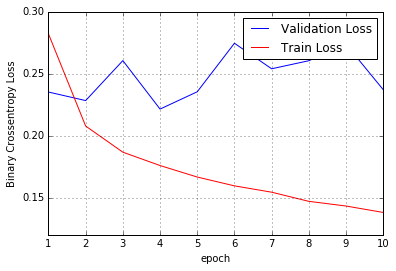

In [35]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))

vy = h.history['val_loss']
ty = h.history['loss']
plt_dynamic(x, vy, ty, ax)

> We got an accuracy of 91.15% that to we ran 10 epochs and we can observe that the difference between train and test loss is low

In [36]:
# create the model
embedding_vecor_length =128
model = Sequential()
model.add(Embedding(70000, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.8))
model.add(LSTM(64))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 128)          8960000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,009,473
Trainable params: 9,009,473
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
h=model.fit(X_train,
          y_train,
          batch_size=64,
          validation_data=(X_test, y_test),
          epochs=10)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 29999 samples
Epoch 1/10
70000/70000 [==============================] - 670s 10ms/step - loss: 0.2755 - acc: 0.8955 - val_loss: 0.2372 - val_acc: 0.9049
Epoch 2/10
70000/70000 [==============================] - 673s 10ms/step - loss: 0.2007 - acc: 0.9253 - val_loss: 0.2304 - val_acc: 0.9101
Epoch 3/10
70000/70000 [==============================] - 671s 10ms/step - loss: 0.1800 - acc: 0.9332 - val_loss: 0.2224 - val_acc: 0.9120
Epoch 4/10
70000/70000 [==============================] - 664s 9ms/step - loss: 0.1682 - acc: 0.9379 - val_loss: 0.2262 - val_acc: 0.9094
Epoch 5/10
70000/70000 [==============================] - 664s 9ms/step - loss: 0.1565 - acc: 0.9430 - val_loss: 0.2305 - val_acc: 0.9108
Epoch 6/10
70000/70000 [==============================] - 664s 9ms/step - loss: 0.1490 - acc: 0.9451 - val_loss: 0.2595 - val_acc: 0.9115
Epoch 7/10
70000/70000 [==============================] - 666s 10ms/step - loss: 0.1435 - acc: 0.9475 - val_loss: 0.277

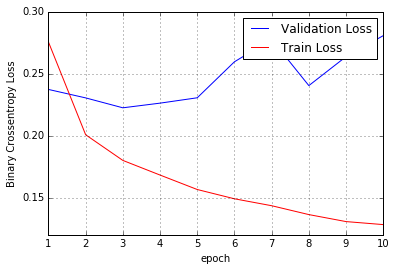

In [38]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))

vy = h.history['val_loss']
ty = h.history['loss']
plt_dynamic(x, vy, ty, ax)

In [5]:
from prettytable import PrettyTable

In [6]:
x = PrettyTable()
x.field_names = ["Embedding Vector length", "LSTM layers", "epochs","Accuracy"]

x.add_row([100, 100, 10,'88.05%'])
x.add_row([128, 192, 5,'90.79%'])
x.add_row([92, 42, 10,'91.15%'])
x.add_row([128, 64, 10,'90.98%'])

In [8]:
print(x)

+-------------------------+-------------+--------+----------+
| Embedding Vector length | LSTM layers | epochs | Accuracy |
+-------------------------+-------------+--------+----------+
|           100           |     100     |   10   |  88.05%  |
|           128           |     192     |   5    |  90.79%  |
|            92           |      42     |   10   |  91.15%  |
|           128           |      64     |   10   |  90.98%  |
+-------------------------+-------------+--------+----------+


>The important part of this assignment is Data preprocessing converting the text data
to LSTM series data.<br> 
>The Padding the data for Batch Performance. <br>
>Then choosing the parameters. <br>
>And, the final thing getting goo accuracy we got about 90% that is good.
> We got the best accuracy of 91.15% with 92 embedding vector length and LSTM layers of 42